# Эксперименты с данными и моделями

## Технический блок кода

### Импорты

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# собственные функции
from own_functions import fit_epoch, eval_epoch, train_model, training_visualisation, metrics_evaluation


ok


### Константы

In [2]:
BATCH = 64              # размер батча
EPOCHS = 10             # количество эпох
LEARNING_RATE = 0.0003  # learning rate оптимайзера

## Влияние "белых прямоугольников" на качество предсказания модели

**Гипотеза**.  
Искусственно созданные "белые прямоугольники" на справках из датасета могут ухудшить точность модели. "Белые прямоугольники" расположены, как правило, в верней части справки, выделяются по контрасту на фоне справки и поэтому могут быть использованы моделью как признак, позволящий определить ориентацию документа. Как результат - точность модели на реальных изображениях без "белых прямоугольников" может быть ниже, чем точность на тестовых данных с "прямоугольниками".

**Дизайн эксперимента**.  
Обучить модель на тренировочной выборке с исходными данными. Проверить ее точность на тестовых данных заказчика (с "белыми прямоугольниками"), а также на тех же изображениях без белых прямоугольников и сравнить метрики. Удалить белые прямоугольники предполагается с помощью графического редактора.

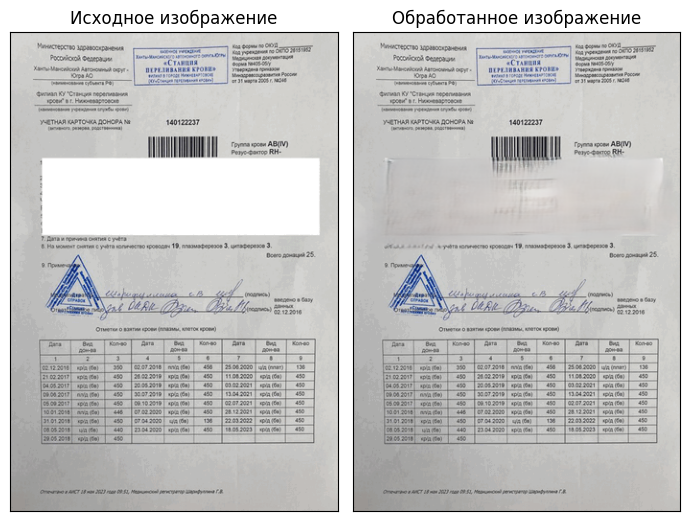

In [3]:
# Пример исходного изображения и изображения с удаленными "белыми прямоугольниками"
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
img1 = mpimg.imread('data/img_dir/405___a2ab612fdf874641abb4b34014b60158.png')
img2 = mpimg.imread('data/img_dir_clear/405___a2ab612fdf874641abb4b34014b60158.png')
axes[0].imshow(img1)
axes[1].imshow(img2)
axes[0].set_title('Исходное изображение')
axes[1].set_title('Обработанное изображение')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
# Опеределение девайса
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
# Трансформации изображения перед загрузкой
transform = transforms.Compose([
    transforms.Resize((128, 128)), # приводим изображения к единому размеру
    transforms.ToTensor() # преобразуем изображение в тензор
])

In [6]:
# Загрузка данных
train_data = datasets.ImageFolder(root='data/img_dir_train', transform=transform)
valid_data = datasets.ImageFolder(root='data/img_dir_valid', transform=transform)
test_data = datasets.ImageFolder(root='data/img_dir_test', transform=transform)     # тест исходные данные
test_data_2 = datasets.ImageFolder(root='data/img_dir_test_2', transform=transform)   # тест: те же изображения, но без "прямоугольников"

In [7]:
# Проверка корректности загрузки, отобразим размеры сетов
print(f'Размер тренировочного сета: {len(train_data)}',
      f'\nРазмер валидационного сета: {len(valid_data)}',
      f'\nРазмер тестового сета: {len(test_data)}',
      f'\nРазмер тестового сета №2: {len(test_data_2)}')

Размер тренировочного сета: 440 
Размер валидационного сета: 108 
Размер тестового сета: 144 
Размер тестового сета №2: 144


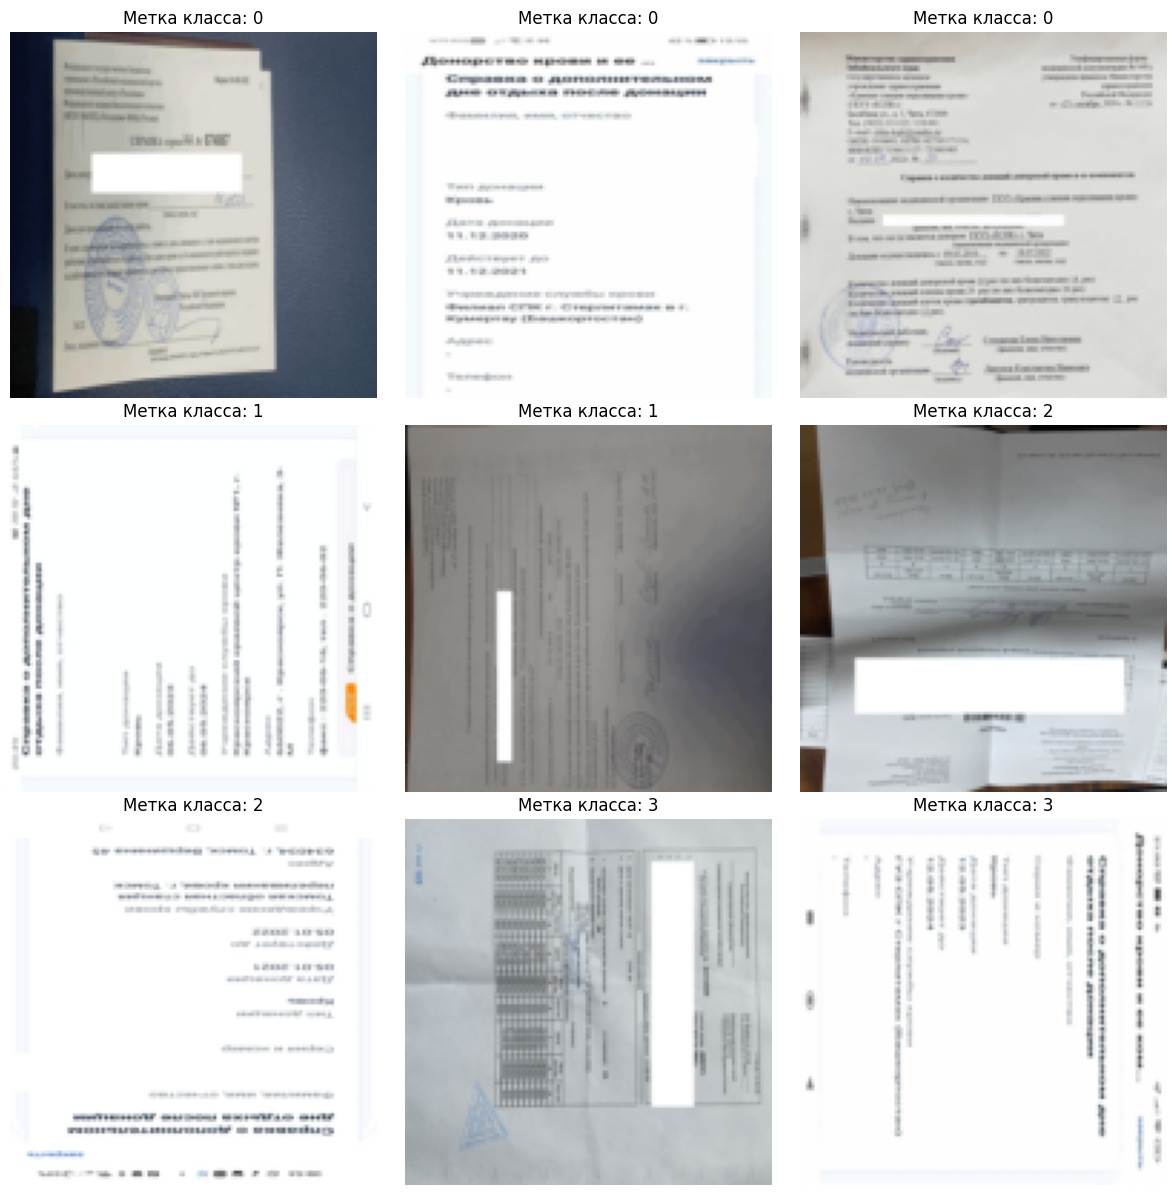

In [8]:
# Отрисуем примеры из тренировочного сета
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
      image_, label = train_data[i * len(train_data) // 9]
      ax.imshow(image_.permute(1, 2, 0))
      ax.set_title(f'Метка класса: {label}')
      ax.axis('off') # hide axis
      plt.tight_layout() # auto alignment

In [9]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=BATCH, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH, shuffle=False)
test_loader_2 = DataLoader(test_data_2, batch_size=BATCH, shuffle=False)

### ResNet50

In [10]:
# Определение модели
class ResNetCLF(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        layers = list(self.resnet.children())
        for layer in layers[-4:]:
            for param in layer.parameters():
                param.requires_grad = True
        self.fc = nn.Linear(1000, 4)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [11]:
# Создание экземпляра модели
model_rn = ResNetCLF()

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(model_rn.parameters())
criterion = nn.CrossEntropyLoss()

d:\.DATASCIENCE\projects\donor_search\donor_search_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\.DATASCIENCE\projects\donor_search\donor_search_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
summary(model_rn, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
history = train_model(train_loader, valid_loader, model=model_rn, epochs=EPOCHS, rate=LEARNING_RATE, criterion=criterion, device=device)

epoch:  10%|█         | 1/10 [00:23<03:34, 23.86s/it]


Epoch 001 train_loss: 0.8098                  val_loss 0.6134 train_acc 0.6932 val_acc 0.8611


epoch:  20%|██        | 2/10 [00:46<03:07, 23.40s/it]


Epoch 002 train_loss: 0.0451                  val_loss 0.2376 train_acc 0.9909 val_acc 0.9444


epoch:  30%|███       | 3/10 [01:10<02:44, 23.47s/it]


Epoch 003 train_loss: 0.0160                  val_loss 0.1726 train_acc 0.9932 val_acc 0.9722


epoch:  40%|████      | 4/10 [01:35<02:23, 23.88s/it]


Epoch 004 train_loss: 0.0041                  val_loss 0.0392 train_acc 0.9977 val_acc 0.9907


epoch:  50%|█████     | 5/10 [01:59<02:00, 24.07s/it]


Epoch 005 train_loss: 0.0100                  val_loss 0.0012 train_acc 0.9977 val_acc 1.0000


epoch:  60%|██████    | 6/10 [02:23<01:36, 24.10s/it]


Epoch 006 train_loss: 0.0032                  val_loss 0.0006 train_acc 0.9977 val_acc 1.0000


epoch:  70%|███████   | 7/10 [02:47<01:12, 24.12s/it]


Epoch 007 train_loss: 0.0010                  val_loss 0.0005 train_acc 1.0000 val_acc 1.0000


epoch:  80%|████████  | 8/10 [03:11<00:47, 23.87s/it]


Epoch 008 train_loss: 0.0003                  val_loss 0.0004 train_acc 1.0000 val_acc 1.0000


epoch:  90%|█████████ | 9/10 [03:34<00:23, 23.71s/it]


Epoch 009 train_loss: 0.0003                  val_loss 0.0004 train_acc 1.0000 val_acc 1.0000


epoch: 100%|██████████| 10/10 [03:57<00:00, 23.75s/it]


Epoch 010 train_loss: 0.0002                  val_loss 0.0004 train_acc 1.0000 val_acc 1.0000


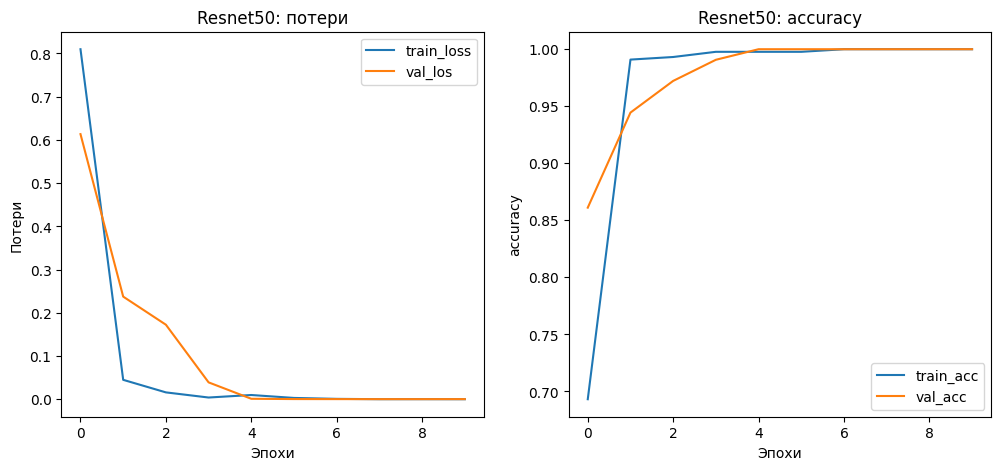

In [14]:
training_visualisation(history, 'Resnet50')

In [15]:
# Создаем датафрейм для хранения метрик
df_metr = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'AUC'],
                       columns=pd.MultiIndex.from_product([['test_1', 'test_2']]))
df_metr

,test_1,test_2
accuracy,NaN,NaN
precision,NaN,NaN
recall,NaN,NaN
f1,NaN,NaN
AUC,NaN,NaN


In [20]:
# Оценим метрики модели на двух тестовых сетах
df_metr['test_1'] = metrics_evaluation(model_rn, test_loader, device=device)
df_metr['test_2'] = metrics_evaluation(model_rn, test_loader_2, device=device)
df_metr

,test_1,test_2
accuracy,0.97,0.93
precision,0.97,0.93
recall,0.97,0.93
f1,0.97,0.93
AUC,1.00,1.00


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

**Выводы**
1. На тестовом сете с удаленными "белыми прямоугольниками" наблюдаем снижение accuracy и других метрик на 4% (с 0.97 до 0.94) по сравнению с тестированием на исходных изображениях.
2. Модель использует "белые прямоугольники" как признак для принятия решения о классификации изображений, что обеспечивает модели около 4% точности.
3. Т.о. гипотеза подтвердилась. Т.к. в реальной работе "белых прямоугольников" не будет, целесообразно обучить модель на сете без "белых прямоугольников".